# Perform deghosting on the whole dataset and stack again

Now I want to deghost the whole dataset, stack and compare this with the previous brute stack.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import rsf.api as sf

%matplotlib inline

# Set a custom DATAPATH to Madagascar
%env DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/

env: DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/


In [2]:
sns.set_style('ticks')

## Apply deghosting using receiver ghosting wavelet

First, let's pad and fourier transform the data.

In [3]:
common_shot = 'line_12_csg_raw.rsf'
common_shot_fourier = 'common_shot_fourier.rsf'

In [4]:
# First let's pad and FFT the shot
!sffft1 < {common_shot} > {common_shot_fourier}

In [5]:
!sfin < {common_shot_fourier}

in:
    in="/home/rodrigo/Projetos/Viking/DATAPATH/common_shot_fourier.rsf@"
    esize=8 type=complex form=native 
    n1=751         d1=0.166667    o1=0          label1="Frequency" unit1="Hz" 
    n2=120         d2=1           o2=0          label2="Trace" 
    n3=1001        d3=?           o3=?          
	90210120 elements 721680960 bytes


In [ ]:
# Deghos the entire dataset
rec_deghost = 'receiver_deghost.rsf'
decon_operator = 'receiver_deghost_operator.rsf'

!sfspray n=120 < {decon_operator} | sfspray n=1001 axis=3 | sfmul {common_shot_fourier} |\
    sffft1 inv=y | sfbandpass flo=6 fhi=75 nphi=8 > {rec_deghost}

sffft1: using 2 of 2 threads


# Brute stack with deghosted data

First, sort the data into CDP domain

In [ ]:
deghosted_cdps = 'line_cdp_deghosted.rsf'
header_int = 'line_12_header_int.rsf'

!sfintbin < {rec_deghost} head={header_int} yk=cdp xk=cdpt > {deghosted_cdps}

sfintbin: 2142 of 2142;


Now stack the deghosted CDP data

In [ ]:
mask = 'line_cdp_mask.rsf'
offsets = 'line_cdp_offset.rsf'
deghost_stack = 'deghost_brute_stack.rsf'
vstk = 'first_stacking_velocity.rsf'

!sfpow tpow=2 < {deghosted_cdps} | \
    sfnmo velocity={vstk} offset={offsets} mask={mask} half=n | \
    sfstack  | sfagc > {deghost_stack}

sfnmo: CMP 2142 of 2142;MP 493 of 2142;CMP 661 of 2142;CMP 785 of 2142;CMP 829 of 2142;CMP 880 of 2142;CMP 2027 of 2142;CMP 2038 of 2142;


In [ ]:
from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
img = sf.Input(deghost_stack)

n1 = img.int('n1')
n2 = img.int('n2')
d1 = img.float('d1')
o1 = img.float('o1')
d2 = img.float('d2')
o2 = img.float('o2')

data = np.zeros((n2, n1), dtype=np.float32)
img.read(data)

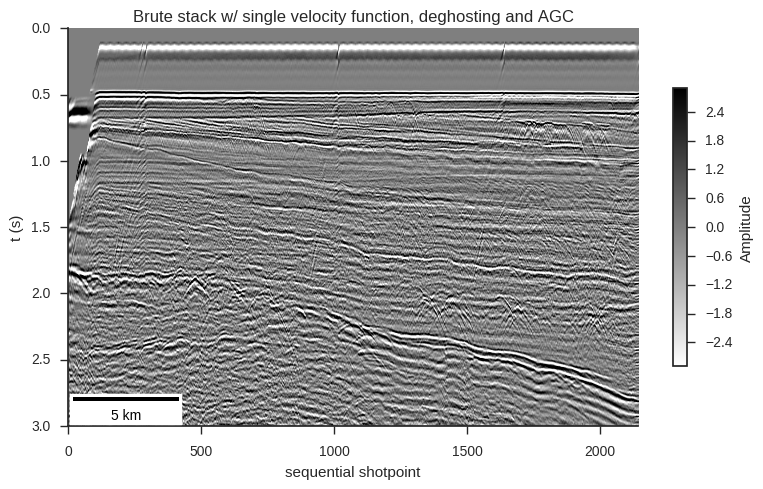

In [ ]:
perc = np.percentile(data.ravel(), 99)
t = np.arange(n1) * d1 + o1
extent = [0, n2, t[-1], o1]
plt.figure(figsize=(8, 5))
img = plt.imshow(data.clip(-perc, perc).T, aspect='auto',
                 extent=extent, cmap='gray_r')


scalebar = ScaleBar(12.5, location='lower left') # 1 pixel = 25 meter
plt.gca().add_artist(scalebar)

plt.ylabel('t (s)')
plt.xlabel('sequential shotpoint')

plt.ylim(3,0)

plt.title('Brute stack w/ single velocity function, deghosting and AGC')

sns.despine()
plt.colorbar(img, shrink=0.7, label='Amplitude')

plt.tight_layout()

In [ ]:
# CDP window
start = 1502 - 5
lenght = 10

cdp_sample = 'deghost_cdp_sample.rsf'
offset_sample = 'offset_cdp_sample.rsf'
mask_sample = 'mask_cdp_sample.rsf'

In [ ]:
!sfwindow < {deghosted_cdps} f3={start} n3={lenght} > {cdp_sample}

In [ ]:
v0=1.3
dv=0.025
nv=90

semblance = 'deghost_semblance.rsf'

!sfagc < {cdp_sample} tpow=2 | sfvscan offset={offset_sample} mask={mask_sample} half=n \
     semblance=y v0={v0} nv={nv} dv={dv} nb=5  | sfstack axis=3 > {semblance}

sfvscan: cmp 10 of 10;


In [ ]:
img = sf.Input(semblance)

n1 = img.int('n1')
n2 = img.int('n2')
d1 = img.float('d1')
o1 = img.float('o1')
d2 = img.float('d2')
o2 = img.float('o2')

data = np.zeros((n2, n1), dtype=np.float32)
img.read(data)

In [ ]:
# Importing Well 5 RMS profile
rms = pd.read_csv('well_5_rms_profile.txt')
picks = pd.read_csv('first_velan_picks.csv')

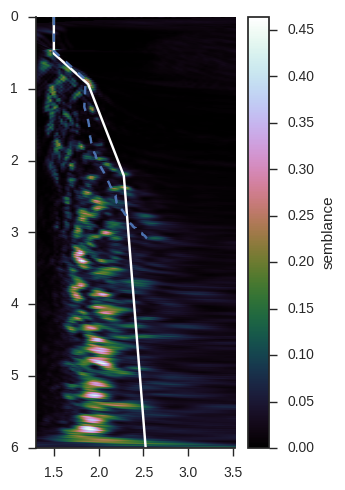

In [ ]:
t = np.arange(n1)*d1 + o1
x = np.arange(n2)*d2 + o2
extent=[x[0], x[-1], t[-1], t[0]]

x, t = np.meshgrid(x,t)

plt.figure(figsize=(3.5,5))
img = plt.imshow(data.T, aspect='auto', cmap='cubehelix', extent=extent)
#plt.contour(x, t, data.T, 3, colors='k', linewidths=1)
plt.plot(picks.VSTK, picks.TWT, color='white')
plt.plot(rms.VRMS/1000., rms.TWT, ls='--')
sns.despine()
plt.axis('tight')
plt.colorbar(img, label='semblance')

plt.tight_layout()